In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Project_DL/vinbigdata/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Project_DL/vinbigdata/test.csv')
imgdir = '/content/drive/MyDrive/Project_DL/vinbigdata/train/'


In [4]:
print(df_train.shape)
df_train_nor= df_train[df_train.class_name == 'No finding']
df_train_nor = df_train_nor.dropna(axis = 1, how = 'any')
display(df_train_nor.head())
print(df_train_nor.shape)
df_train_abnor= df_train[df_train.class_name != 'No finding']
display(df_train_abnor.head())
print(df_train_abnor.shape)

(67914, 10)


,image_id,class_name,class_id,rad_id,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,2954,3159
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,2540,3072
12,5550a493b1c4554da469a072fdfab974,No finding,14,R9,3072,3072
13,869f39afbdd8783b531530942eda8bad,No finding,14,R3,3072,3072


(31818, 6)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353


(36096, 10)


In [5]:
df_train_nor.image_id= df_train_nor.image_id.apply(lambda x: imgdir+ x+ '.png')
namelist_nor = df_train_nor.image_id.unique()

In [6]:
df_train_abnor.image_id= df_train_abnor.image_id.apply(lambda x: imgdir+ x+ '.png')
namelist_abnor = df_train_abnor.image_id.unique()
namelist_abnor

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array(['/content/drive/MyDrive/Project_DL/vinbigdata/train/9a5094b2563a1ef3ff50dc5c7ff71345.png',
       '/content/drive/MyDrive/Project_DL/vinbigdata/train/051132a778e61a86eb147c7c6f564dfe.png',
       '/content/drive/MyDrive/Project_DL/vinbigdata/train/1c32170b4af4ce1a3030eb8167753b06.png',
       ...,
       '/content/drive/MyDrive/Project_DL/vinbigdata/train/380d07a94cc4b012812119370de47192.png',
       '/content/drive/MyDrive/Project_DL/vinbigdata/train/52951d7de2485aba8ed62629eee4d254.png',
       '/content/drive/MyDrive/Project_DL/vinbigdata/train/1224f07d895107573588225f692e94f9.png'],
      dtype=object)

In [7]:
img_data =[]
# for i in range(len(namelist_nor)):
for i in range(1000):
    image = cv2.imread(namelist_nor[i])
    image = image.astype('float32')
    image /= 255 
    img_data.append(image)
img_data = np.array(img_data)
print(img_data.shape)

(1000, 512, 512, 3)


In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(512, 512, 3))
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 262144)       0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 128 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((128, 128, 16))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 262144)            1048576   
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 512, 512, 16)      2320      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 512, 512, 3)       435       
Total params: 1,053,651
Trainable params: 1,053,651
Non-trainable params: 0
_________________________________________________

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(img_data, epochs=30, batch_size=32)

Epoch 1/30
32/32 [==============================] - 11s 241ms/step - loss: 181036.4110 - reconstruction_loss: 179546.5938 - kl_loss: 406.1447
Epoch 2/30
32/32 [==============================] - 7s 232ms/step - loss: 169272.5573 - reconstruction_loss: 167709.8906 - kl_loss: 83.0007
Epoch 3/30
32/32 [==============================] - 7s 232ms/step - loss: 165714.7401 - reconstruction_loss: 165057.6719 - kl_loss: 82.8811
Epoch 4/30
32/32 [==============================] - 7s 234ms/step - loss: 164513.0213 - reconstruction_loss: 163556.6875 - kl_loss: 83.1714
Epoch 5/30
32/32 [==============================] - 7s 234ms/step - loss: 162708.4948 - reconstruction_loss: 162382.8125 - kl_loss: 73.6815
Epoch 6/30
32/32 [==============================] - 8s 234ms/step - loss: 161702.1155 - reconstruction_loss: 161241.4531 - kl_loss: 71.5073
Epoch 7/30
32/32 [==============================] - 8s 235ms/step - loss: 160044.2509 - reconstruction_loss: 159892.8438 - kl_loss: 74.4218
Epoch 8/30
32/32 [

# Test ảnh thường

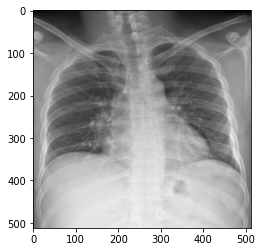

In [29]:
#test 1 ảnhảnh
x_test = cv2.imread(namelist_nor[2000]).astype("float32") / 255
plt.imshow(x_test)
x_test = np.expand_dims(x_test, axis = 0)

In [30]:
# lớp latent
x_test_encoded = encoder.predict(x_test)
x_test_encoded = np.array(x_test_encoded)
print(x_test_encoded)
z_mean = np.array(x_test_encoded[0,:,:])
z_log_var = np.array(x_test_encoded[1,:,:])
z = np.array(x_test_encoded[2,:,:])

[[[ -1.2992973   7.1226497  -2.3529155]]

 [[ -9.79625    -7.5340896 -10.893033 ]]

 [[ -1.2847296   7.1130924  -2.3508005]]]


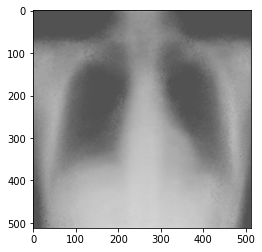

In [31]:
#ảnh đầu ra 
x_test_decoded = decoder.predict(z)
x_test_decoded.shape
x_test_decoded = np.squeeze(x_test_decoded, axis = 0)
plt.imshow(x_test_decoded)

In [32]:
#in ra losloss của ảnhảnh
x_test = cv2.imread(namelist_nor[2000]).astype("float32") / 255
reconstruction_loss = cost = tf.reduce_mean(tf.pow(tf.subtract(x_test,x_test_decoded),2))
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
total_loss = reconstruction_loss + kl_loss
print(total_loss)

tf.Tensor(41.601944, shape=(), dtype=float32)


In [ ]:
# tìm loss range của tập ảnh thường để set threshold 

# Test ảnh bất thường

[[[ -4.52279     7.78398    -2.0062368]]

 [[-15.653485   -9.719559  -14.113388 ]]

 [[ -4.5230565   7.7808037  -2.0073462]]]
tf.Tensor(60.804302, shape=(), dtype=float32)


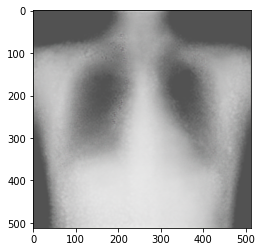

In [27]:
x_test = cv2.imread(namelist_abnor[4000]).astype("float32") / 255
plt.imshow(x_test)
x_test = np.expand_dims(x_test, axis = 0)
x_test_encoded = encoder.predict(x_test)
x_test_encoded = np.array(x_test_encoded)
print(x_test_encoded)
z_mean = np.array(x_test_encoded[0,:,:])
z_log_var = np.array(x_test_encoded[1,:,:])
z = np.array(x_test_encoded[2,:,:])
x_test_decoded = decoder.predict(z)
x_test_decoded.shape
x_test_decoded = np.squeeze(x_test_decoded, axis = 0)
plt.imshow(x_test_decoded)
x_test = cv2.imread(namelist_abnor[4000]).astype("float32") / 255
reconstruction_loss = cost = tf.reduce_mean(tf.pow(tf.subtract(x_test,x_test_decoded),2))
kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
total_loss = reconstruction_loss + kl_loss
print(total_loss)

In [ ]:
# tìm loss range của tập ảnh bất thường để set threshold 

In [ ]:
#set threshold cho error để chia làm 2 loại normal và abnormal
